In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os

In [5]:
jellyfish_dir = "/aiffel/aiffel/jellyfish/"
# Define the path to the dataset folders
Moon_jellyfish_folder = jellyfish_dir + "Moon_jellyfish"
barrel_jellyfish_folder = jellyfish_dir + "barrel_jellyfish"
blue_jellyfish_folder = jellyfish_dir + "blue_jellyfish"
compass_jellyfish_folder = jellyfish_dir + "compass_jellyfish"
lions_mane_jellyfish_folder = jellyfish_dir + "lions_mane_jellyfish"
mauve_stinger_jellyfish_folder = jellyfish_dir + "mauve_stinger_jellyfish"



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Moon_jellyfish_folder = "/kaggle/input/jellyfish-types/Moon_jellyfish"
# barrel_jellyfish_folder = "/kaggle/input/jellyfish-types/barrel_jellyfish"
# blue_jellyfish_folder = "/kaggle/input/jellyfish-types/blue_jellyfish"
# compass_jellyfish_folder = "/kaggle/input/jellyfish-types/compass_jellyfish"
# lions_mane_jellyfish_folder = "/kaggle/input/jellyfish-types/lions_mane_jellyfish"
# mauve_stinger_jellyfish_folder = "/kaggle/input/jellyfish-types/mauve_stinger_jellyfish"

# Load images and labels for each emotion
Moon_images = load_images_from_folder(Moon_jellyfish_folder)
barrel_images = load_images_from_folder(barrel_jellyfish_folder)
blue_images = load_images_from_folder(blue_jellyfish_folder)
compass_images = load_images_from_folder(compass_jellyfish_folder)
lions_mane_images = load_images_from_folder(lions_mane_jellyfish_folder)
mauve_stinger_images = load_images_from_folder(mauve_stinger_jellyfish_folder)


# Create labels for each emotion category
Moon_labels = [0] * len(Moon_images)
barrel_labels = [1] * len(barrel_images)
blue_labels = [2] * len(blue_images)
compass_labels = [3] * len(compass_images)
lions_mane_labels = [4] * len(lions_mane_images)
mauve_stinger_labels = [5] * len(mauve_stinger_images)

all_labels = Moon_labels+barrel_labels+blue_labels+compass_labels+lions_mane_labels+mauve_stinger_labels 

In [7]:
len(all_labels)

900

In [8]:
print('Moon_jellyfish_images: ',len(Moon_images))
print('barrel_jellyfish_images: ',len(barrel_images))
print('blue_jellyfish_images: ',len(blue_images))
print('compass_jellyfish_images: ',len(compass_images))
print('lions_mane_jellyfish_images: ',len(lions_mane_images))
print('mauve_stinger_jellyfish_images: ',len(mauve_stinger_images))
Moon_jellyfish_images:  150
barrel_jellyfish_images:  150
blue_jellyfish_images:  150
compass_jellyfish_images:  150
lions_mane_jellyfish_images:  150
mauve_stinger_jellyfish_images:  150

Moon_jellyfish_images:  150
barrel_jellyfish_images:  150
blue_jellyfish_images:  150
compass_jellyfish_images:  150
lions_mane_jellyfish_images:  150
mauve_stinger_jellyfish_images:  150


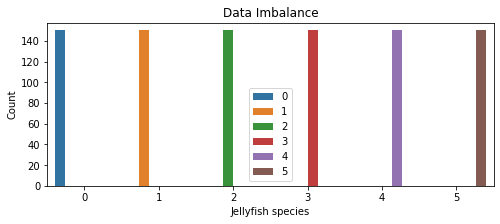

In [9]:
# Data Imbalance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))
sns.countplot(x=all_labels, hue=all_labels)
plt.title('Data Imbalance')
plt.xlabel('Jellyfish species')
plt.ylabel('Count')
plt.show()

In [10]:
# Concatenate images and labels
X = np.array(Moon_images + barrel_images + blue_images + compass_images + lions_mane_images + mauve_stinger_images)
y = np.array(Moon_labels + barrel_labels + blue_labels + compass_labels + lions_mane_labels + mauve_stinger_labels)

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = np_utils.to_categorical(y, 6)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
input_shape_resnet = (224, 224, 3)
input_shape_densenet = (224, 224, 3)
input_shape_efficientnet = (224, 224, 3)

def resize_images(images, input_shape):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (input_shape[0], input_shape[1]))
        img_resized = np.expand_dims(img_resized, axis=-1)
        img_resized = np.repeat(img_resized, 3, axis=-1)  # Add three channels to convert grayscale to RGB
        resized_images.append(img_resized)
    return np.array(resized_images)

X_train_resized_resnet = resize_images(X_train, input_shape_resnet)
X_train_resized_densenet = resize_images(X_train, input_shape_densenet)
X_train_resized_efficientnet = resize_images(X_train, input_shape_efficientnet)


In [12]:
# Load pre-trained ResNet50 model and remove the top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)
resnet_base_model.trainable = False

# Add custom classification head to the ResNet model
resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(6, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

# Compile the ResNet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_densenet)
densenet_base_model.trainable = False


densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(6, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)


densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-7)

# Train the models
'''
train the models on resized training data and validation split,
monitoring the validation loss and using the
early stopping and learning rate scheduling callbacks to stop when necessary.
'''

resnet_history = resnet_model.fit(X_train_resized_resize=32, epochs=200, validation_split=0.2,callbacks=[early_stopping, lr_scheduler])net, y_train, batch_size=32, epochs=200, validation_split=0.2,callbacks=[early_stopping, lr_scheduler])
densenet_history = densenet_model.fit(X_train_resized_densenet, y_train, batch_s

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/200
18/18 [==============================] - 44s 216ms/step - loss: 1.8301 - accuracy: 0.1493 - val_loss: 1.8359 - val_accuracy: 0.1667
Epoch 2/200
18/18 [==============================] - 2s 118ms/step - loss: 1.8007 - accuracy: 0.1597 - val_loss: 1.7924 - val_accuracy: 0.1944
Epoch 3/200
18/18 [==============================] - 2s 119ms/step - loss: 1.7937 - accuracy: 0.1875 - val_loss: 1.8095 - val_accuracy: 0.1806
Epoch 4/200
18/18 [==============================] - 2s 119ms/step - loss: 1.7940 - accuracy: 0.1875 - val_loss: 1.7861 - val_accuracy: 0.1667
Epoch 5/200
18/18 [==============================] - 2s 120ms/step - loss: 1.7873 - accuracy: 0.1892 - val_loss: 1.7662 - val_accuracy: 0.2917
Epoch 6/200
18/18 [==============================] - 2s 120ms/step - loss: 1.7704 - accuracy: 0.1962 - val_loss: 1.7743 - val_accuracy: 0.2361
Epoch 7/200
18/18 [==============================] - 2s 120ms/step - loss: 1

18/18 [==============================] - 2s 118ms/step - loss: 1.6511 - accuracy: 0.3247 - val_loss: 1.6099 - val_accuracy: 0.3403
Epoch 55/200
18/18 [==============================] - 2s 118ms/step - loss: 1.6313 - accuracy: 0.3750 - val_loss: 1.6160 - val_accuracy: 0.3958
Epoch 56/200
18/18 [==============================] - 2s 119ms/step - loss: 1.6261 - accuracy: 0.3524 - val_loss: 1.6207 - val_accuracy: 0.4097
Epoch 57/200
18/18 [==============================] - 2s 119ms/step - loss: 1.6218 - accuracy: 0.3559 - val_loss: 1.6381 - val_accuracy: 0.3194
Epoch 58/200
18/18 [==============================] - 2s 117ms/step - loss: 1.6254 - accuracy: 0.3264 - val_loss: 1.6116 - val_accuracy: 0.3750
Epoch 59/200
18/18 [==============================] - 2s 118ms/step - loss: 1.6208 - accuracy: 0.3368 - val_loss: 1.6442 - val_accuracy: 0.2639
Epoch 60/200
18/18 [==============================] - 2s 131ms/step - loss: 1.6194 - accuracy: 0.3490 - val_loss: 1.5987 - val_accuracy: 0.3750
Epoch

Epoch 111/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5694 - accuracy: 0.4028 - val_loss: 1.5692 - val_accuracy: 0.3681
Epoch 112/200
18/18 [==============================] - 2s 119ms/step - loss: 1.5663 - accuracy: 0.3854 - val_loss: 1.5661 - val_accuracy: 0.3819
Epoch 113/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5693 - accuracy: 0.3872 - val_loss: 1.5733 - val_accuracy: 0.4167
Epoch 114/200
18/18 [==============================] - 2s 119ms/step - loss: 1.5664 - accuracy: 0.3837 - val_loss: 1.5675 - val_accuracy: 0.3958
Epoch 115/200
18/18 [==============================] - 2s 119ms/step - loss: 1.5630 - accuracy: 0.4028 - val_loss: 1.5695 - val_accuracy: 0.3889
Epoch 116/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5643 - accuracy: 0.4097 - val_loss: 1.5634 - val_accuracy: 0.3472
Epoch 117/200
18/18 [==============================] - 2s 119ms/step - loss: 1.5687 - accuracy: 0.3837 - val_loss: 1.5672 - val_ac

18/18 [==============================] - 2s 118ms/step - loss: 1.5256 - accuracy: 0.4288 - val_loss: 1.5447 - val_accuracy: 0.3750
Epoch 168/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5299 - accuracy: 0.4028 - val_loss: 1.5389 - val_accuracy: 0.4028
Epoch 169/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5253 - accuracy: 0.4219 - val_loss: 1.5328 - val_accuracy: 0.3958
Epoch 170/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5236 - accuracy: 0.4132 - val_loss: 1.5400 - val_accuracy: 0.4028
Epoch 171/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5232 - accuracy: 0.4410 - val_loss: 1.5386 - val_accuracy: 0.4167
Epoch 172/200
18/18 [==============================] - 2s 117ms/step - loss: 1.5244 - accuracy: 0.4080 - val_loss: 1.5363 - val_accuracy: 0.3958
Epoch 173/200
18/18 [==============================] - 2s 118ms/step - loss: 1.5363 - accuracy: 0.3906 - val_loss: 1.5396 - val_accuracy: 0.3889

Epoch 24/200
18/18 [==============================] - 2s 117ms/step - loss: 0.1750 - accuracy: 0.9705 - val_loss: 0.2700 - val_accuracy: 0.9097
Epoch 25/200
18/18 [==============================] - 2s 117ms/step - loss: 0.1671 - accuracy: 0.9757 - val_loss: 0.2587 - val_accuracy: 0.9306
Epoch 26/200
18/18 [==============================] - 2s 116ms/step - loss: 0.1606 - accuracy: 0.9722 - val_loss: 0.2566 - val_accuracy: 0.9167
Epoch 27/200
18/18 [==============================] - 2s 116ms/step - loss: 0.1549 - accuracy: 0.9792 - val_loss: 0.2502 - val_accuracy: 0.9167
Epoch 28/200
18/18 [==============================] - 2s 116ms/step - loss: 0.1482 - accuracy: 0.9809 - val_loss: 0.2432 - val_accuracy: 0.9375
Epoch 29/200
18/18 [==============================] - 2s 116ms/step - loss: 0.1456 - accuracy: 0.9826 - val_loss: 0.2481 - val_accuracy: 0.9236
Epoch 30/200
18/18 [==============================] - 2s 116ms/step - loss: 0.1384 - accuracy: 0.9844 - val_loss: 0.2397 - val_accuracy:

Epoch 81/200
18/18 [==============================] - 2s 117ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.1433 - val_accuracy: 0.9514
Epoch 82/200
18/18 [==============================] - 2s 117ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.1453 - val_accuracy: 0.9375
Epoch 83/200
18/18 [==============================] - 2s 117ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9514
Epoch 84/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.9444
Epoch 85/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9375
Epoch 86/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.1406 - val_accuracy: 0.9514
Epoch 87/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0310 - accuracy: 1.0000 - val_loss: 0.1402 - val_accuracy:

18/18 [==============================] - 2s 116ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.1237 - val_accuracy: 0.9514
Epoch 138/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1236 - val_accuracy: 0.9514
Epoch 139/200
18/18 [==============================] - 2s 117ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.1240 - val_accuracy: 0.9514
Epoch 140/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.1231 - val_accuracy: 0.9444
Epoch 141/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.1232 - val_accuracy: 0.9514
Epoch 142/200
18/18 [==============================] - 2s 115ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.1231 - val_accuracy: 0.9514
Epoch 143/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.1221 - val_accuracy: 0.9444

18/18 [==============================] - 2s 116ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9514
Epoch 194/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1167 - val_accuracy: 0.9583
Epoch 195/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1171 - val_accuracy: 0.9514
Epoch 196/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 0.9514
Epoch 197/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 0.9514
Epoch 198/200
18/18 [==============================] - 2s 117ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9514
Epoch 199/200
18/18 [==============================] - 2s 116ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1168 - val_accuracy: 0.9514

In [13]:
# Resize test images to the input shape required by each model
X_test_resized_densenet = resize_images(X_test, input_shape_densenet)
X_test_resized_resnet = resize_images(X_test, input_shape_resnet)

# Evaluate the models on test data
densenet_loss, densenet_accuracy = densenet_model.evaluate(X_test_resized_densenet, y_test)
resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test_resized_resnet, y_test)

print("\n")
print("DenseNet Test accuracy:", densenet_accuracy)
print("ResNet Test accuracy:", resnet_accuracy)

SyntaxError: invalid syntax (1261658693.py, line 12)

In [ ]:
import matplotlib.pyplot as plt


def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()


def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()


fig, axs = plt.subplots(2, 2, figsize=(20, 15))
plot_learning_curves(densenet_history, 'DenseNet', axs[0, 0])
plot_accuracy_curves(densenet_history, 'DenseNet', axs[0, 1])

plot_learning_curves(resnet_history, 'ResNet', axs[1, 0])
plot_accuracy_curves(resnet_history, 'ResNet', axs[1, 1])


plt.tight_layout()
plt.show()